In [1]:
# check pytorch version
import torch
print(torch.__version__)


1.4.0


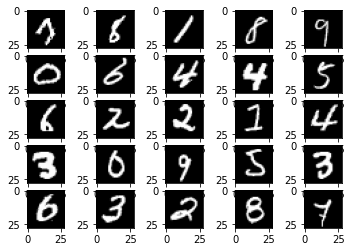

In [2]:
# load mnist dataset in pytorch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from matplotlib import pyplot
# define location to save or load the dataset
path = '~/.torch/datasets/mnist'
# define the transforms to apply to the data
trans = Compose([ToTensor()])
# download and define the datasets
train = MNIST(path, train=True, download=True, transform=trans)
test = MNIST(path, train=False, download=True, transform=trans)
# define how to enumerate the datasets
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)
# get one batch of images
i, (inputs, targets) = next(enumerate(train_dl))
# plot some images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(inputs[i][0], cmap='gray')
# show the figure
pyplot.show()

In [5]:
# pytorch cnn for multiclass classification
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
# model definition
class CNN(Module):
    # define model elements
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        
        self.model_file = 'mnist/model.pt'
        
        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        # fully connected layer
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # flatten
        X = X.view(-1, 4*4*50)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X
    
    def save_to_file(self):
        torch.save(self.state_dict(),self.model_file)
        
    def load_from_file(self):
        self.load_state_dict(torch.load(self.model_file))
        self.eval()

class Trainer:
    def __init__(self):
        self.path = '~/.torch/datasets/mnist'
        
    # prepare the dataset
    def prepare_data(self):
        # define standardization
        trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
        # load dataset
        train = MNIST(self.path, train=True, download=True, transform=trans)
        test = MNIST(self.path, train=False, download=True, transform=trans)
        # prepare data loaders
        train_dl = DataLoader(train, batch_size=64, shuffle=True)
        test_dl = DataLoader(test, batch_size=1024, shuffle=False)
        return train_dl, test_dl
 
    # train the model
    def train_model(self,train_dl, model):
        # define the optimization
        criterion = CrossEntropyLoss()
        optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
        # enumerate epochs
        for epoch in range(10):
            print(f'epoch {epoch}')
            # enumerate mini batches
            for i, (inputs, targets) in enumerate(train_dl):
                if i % 100 == 0:
                    print(f'batch {i}')
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, targets)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()
 
    def evaluate_inputs(self,inputs, model):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        return yhat

    # evaluate the model
    def evaluate_model(self,test_dl, model):
        predictions, actuals = list(), list()
        for i, (inputs, targets) in enumerate(test_dl):
            # evaluate the model on the test set
            yhat = evaluate_inputs(inputs,model)

            actual = targets.numpy()
            # reshape for stacking
            actual = actual.reshape((len(actual), 1))
            yhat = yhat.reshape((len(yhat), 1))
            # store
            predictions.append(yhat)
            actuals.append(actual)
        predictions, actuals = vstack(predictions), vstack(actuals)
        # calculate accuracy
        acc = accuracy_score(actuals, predictions)
        return acc
 
    def run_training(self):
        # prepare the data
        train_dl, test_dl = self.prepare_data()
        print(len(train_dl.dataset), len(test_dl.dataset))
        # define the network
        model = CNN(1)
        # # train the model
        self.train_model(train_dl, model)
        model.save_to_file()
        # evaluate the model
        acc = self.evaluate_model(test_dl, model)
        print('Accuracy: %.3f' % acc)
    
    def test_sample(self):
        train_dl, test_dl = self.prepare_data()
        i, (inputs, targets) = next(enumerate(test_dl))
        model = CNN(1)
        model.load_from_file()
        inputs = inputs[0:5] # just first five
        outputs = self.evaluate_inputs(inputs, model)
        return inputs, outputs

trainer = Trainer()
# train by running the following, which will create a model file that will be used for testing
# trainer.run_training()


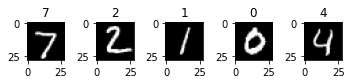

In [6]:
# Run a test using the model file for a small sample

inputs, outputs = trainer.test_sample()
for i in range(len(inputs)):
    pyplot.subplot(5, 5, i+1)
    pyplot.imshow(inputs[i][0], cmap='gray')
    pyplot.title(f'{outputs[i]}')
pyplot.show()
